Import appropriate packages

In [89]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot.imshow import imshow_grid_at_node
from landlab.plot import plot_network_and_parcels
from landlab.io import read_shapefile
from landlab.io.esri_ascii import read_esri_ascii

%matplotlib inline

First try--let the NetworkModelGrid create a grid (it won't be perfect and we hack it into shape later)

In [18]:
shp_file = r'data\hugo_links.shp'

grid = read_shapefile(
    shp_file,
#     points_shapefile=points_shapefile,
    node_fields=["usarea_km2", "Elev_m"],
    link_fields=["usarea_km2", "Length_m"],
    link_field_conversion={"usarea_km2": "drainage_area", "Slope":"channel_slope", "Length_m":"reach_length"},
    node_field_conversion={
        "usarea_km2": "drainage_area",
        "Elev_m": "topographic__elevation",
    },
    threshold=65,
    )

Plot our grid (notice the overlapping points)

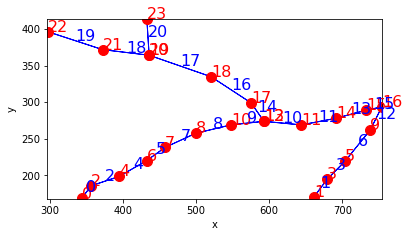

In [22]:
graph.plot_graph(grid, at="node,link")

Nodes we don't want: 19, 13
* reassign all nodes_at_link that reference the nodes we don't want: 19-> 20, 13->12

In [74]:
drop_nodes = [19, 13]
replace_nodes = [20, 12]
new_y_of_node = []
new_x_of_node = []
for i, node in enumerate(grid.y_of_node):
    if i not in drop_nodes:
        new_y_of_node.append(node)
        
for i, node in enumerate(grid.x_of_node):
    if i not in drop_nodes:
        new_x_of_node.append(node)
        
#redirect all nodes to correct reference
nodes_reformatted = np.ravel(grid.nodes_at_link)
for node, replacement in zip(drop_nodes, replace_nodes):
    nodes_reformatted[np.where(nodes_reformatted==node)] = replacement

#reduce all nodes to account for removing nodes
for node in drop_nodes:
    nodes_reformatted[np.where(nodes_reformatted > node)] -= 1

new_nodes_at_link = nodes_reformatted.reshape((21, 2))

Make new grid without these overlapping nodes:

In [76]:
new_grid = NetworkModelGrid((new_y_of_node, new_x_of_node), new_nodes_at_link)

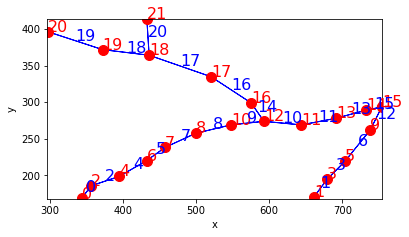

In [78]:
graph.plot_graph(new_grid, at="node,link")

In [80]:
new_grid.number_of_links

21

In [82]:
new_grid.number_of_nodes

22

Yay we now have the correct nodes:

In [86]:
raster_grid_fn = r'data\hugo_site.asc'
rmg,z = read_esri_ascii(raster_grid_fn,name='topographic__elevation')

close all cells that are no data

In [92]:
rmg.status_at_node[np.isclose(z,-9999.)] = rmg.BC_NODE_IS_CLOSED

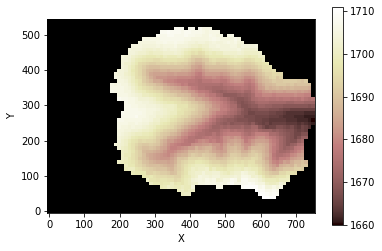

In [94]:
imshow_grid_at_node(rmg, z)

Give network model grid node elevations the nearest raster model grid cell topo value:

In [109]:
nmg_node_topo = np.zeros(new_grid.number_of_nodes) #create empty array holding elevations for network model grid
nmg_node_flow_depth = np.zeros(new_grid.number_of_nodes)

for i in range(new_grid.number_of_nodes):
    idx_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[i], new_grid.y_of_node[i]])
    nmg_node_topo[i] = rmg.at_node["topographic__elevation"][idx_nearest_raster_cell]
    ##insert line here to get flow depths (can do same as above)

Calculate distance between points:

In [116]:
nmg_link_length = np.zeros(new_grid.number_of_links)
slope = np.zeros(new_grid.number_of_links)
for i in range(new_grid.number_of_links):
    idx_node_1_link = new_grid.nodes_at_link[i][0]
    idx_node_2_link = new_grid.nodes_at_link[i][1]
    nmg_link_length[i] = np.sqrt((new_grid.x_of_node[idx_node_2_link] - new_grid.x_of_node[idx_node_1_link])**2 
                         + (new_grid.y_of_node[idx_node_2_link] - new_grid.y_of_node[idx_node_1_link])**2)
    slope[i] = (new_grid.at_node["topographic__elevation"][idx_node_2_link] - new_grid.at_node["topographic__elevation"][idx_node_2_link]) /nmg_link_length[i]

In [119]:
new_grid.at_node["bedrock__elevation"] = nmg_node_topo.copy()

new_grid.at_link["channel_width"] = 1 * np.ones(grid.number_of_links)

grid.at_link["flow_depth"] = 0.5 * np.ones(grid.number_of_links) ## LINK MODELS HERE!!
grid.at_link["channel_slope"] = slope
grid.at_link["reach_length"] = nmg_link_length